## Implementing Monty Hall problem (a.k.a The Three Door Problem) using PyMC

This notebook is meant to provide a basic PyMC implementation of the Monty Hall problem. It is meant for those starting with PyMC who are not used to its syntax to be able to understand it from a familiar problem. 

I did get somewhat sidetracked towards the end and generalised it to an N-door problem.

### Monty Hall Problem

This is a brief summary of the problem, with enough detail to get by. For more details and the history behind it, see [here](https://en.wikipedia.org/wiki/Monty_Hall_problem).

There are 3 doors. There is a car (the prize) behind one door and goats behind the other two. The contestant needs to guess which door has the car to win it. The game is played something like this:

1. The contestant selects a door

2. The host opens an unselected door to reveal a goat

3. The contestant is asked whether they want to stick to their original door or switch to the remaining door

Is the optimal strategy to switch or to stick to the originally selected door?

### 1. Bayes' Theorem / Analytical

#### Prior


The prior probability on where the prize lies is 1/3 for each door.

P(Car = 1) = P(Car = 2) = P(Car = 3) = $\frac{1}{3}$

The host will not open the door that has been selected by the participant or the door with the car. 

#### Likelihood

Let's suppose we have selected door 1.

If the car is in the same door that was selected by the participant, the host will open either of the other two doors. Otherwise, the host is restricted to opening the only remaining losing door.

$P(Goat = 2 | Car = 1) = \frac{1}{2}, P(Goat = 3 | Car = 1) = \frac{1}{2}$

$P(Goat = 2 | Car = 2) = 0, P(Goat = 3 | Car = 2) = 1$

$P(Goat = 2 | Car = 3) = 1, P(Goat = 3 | Car = 3) = 0$



#### Bayes' Rule

Let's suppose the host shows us the goat behind door 2. Applying the Bayes' rule we can find out if switching to door 3 gives us a greater chance of winning the car than sticking to door 1.

$P(A|B) = \frac{P(B|A)P(B)}{P(A)}$

$P(Car = 1 | Goat = 2) = \frac{P(Goat = 2 | Car = 1)}{P(Goat = 2 | Car = 1) + P(Goat = 2 | Car = 3)} = \frac{\frac{1}{2}}{\frac{1}{2} + 1} = \frac{1}{3}$

$P(Car = 3 | Goat = 2) = \frac{P(Goat = 2 | Car = 3)}{P(Goat = 2 | Car = 1) + P(Goat = 2 | Car = 3)} = \frac{1}{\frac{1}{2} + 1} = \frac{2}{3}$

Switching to door 3 makes us twice as likely to win the car

(NB: summing for normalisation, prior term cancels out in Bayes' theorem and is not shown)

In [1]:
# libraries needed
#! pip install pymc3 numba numpy matplotlib

### 2. Python standard library

Simulating the experiment using Python's built-in libraries is quite straightforward. We use the random module to select between doors with uniform probability and see the effect of switching.

In [2]:
import random
random.seed(0)
# random.choice selects a random element from a sequence with equal probability
# i.e. a List of N elements will return each element with 1/N probability

# A single game
def monty_hall(switch: bool, n_doors: int = 3) -> bool:
    # Start with 3 valid doors
    doors = list(range(n_doors)) # [0, 1, 2]
    
    # Pick car door and contestants selection randomly
    car_door = random.choice(doors)
    selected_door = random.choice(doors)
    
    # Host opens a door that the contestant hasn't selected and also isn't a winning door
    goat_door = random.choice([x for x in doors if x not in {car_door, selected_door}])
    doors.remove(goat_door)

    # If contestant switches to the remaining door
    if switch:
        doors.remove(selected_door)
        selected_door = doors.pop()

    return car_door == selected_door

iterations = 10_000
print(f"Chances of winning by switching:\t{sum([monty_hall(True, 3) for _ in range(iterations)])/iterations:.02f}")
print(f"Chances of winning without switching:\t{sum([monty_hall(False, 3) for _ in range(iterations)])/iterations:.02f}")

Chances of winning by switching:	0.67
Chances of winning without switching:	0.34


### 3. PyMC

The same model can be specified using PyMC. PyMC is more extensible and can model more complex priors and selection distributions if needed, but this is a vanilla translation of the above simulation.

In [3]:
import pymc3 as pm
from theano import tensor as tt

iterations = 10_000
n_doors = 3
with pm.Model() as model:
    # Car behind one of 3 doors with equal probability
    car = pm.DiscreteUniform(name="car", lower=0, upper=n_doors-1)
    
    # Contestant selected one of 3 doors with equal probability
    selected = pm.DiscreteUniform(name="selected", lower=0, upper=n_doors-1)
    
    # Host opens another door to show a goat
    # each switch condition corresponds to: 0 if door in (selected, car) else 1
    goat = pm.Categorical(name="goat", p=tt.stack([
        pm.math.switch(pm.math.or_(pm.math.eq(car, i), pm.math.eq(selected, i)), 0, 1) 
        for i in range(n_doors)]))
    
    # Host opens another door to show a goat
    # each switch condition corresponds to: 0 if door in (goat, car) else 1
    switch = pm.Categorical(name="switch", p=tt.stack([
        pm.math.switch(pm.math.or_(pm.math.eq(goat, i), pm.math.eq(selected, i)), 0, 1) 
        for i in range(n_doors)]))
    
    step = pm.Metropolis()
    trace = pm.sample(iterations + 1000, tune=1000, step=step, return_inferencedata=False)
    burned_trace = trace[1000:]
    
trace_len = len(burned_trace['car'])
print(f"Chances of winning by switching:\t{sum(burned_trace['switch'] == burned_trace['car'])/trace_len:.02f}")
print(f"Chances of winning without switching:\t{sum(burned_trace['selected'] == burned_trace['car'])/trace_len:.02f}")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switch]
>Metropolis: [goat]
>Metropolis: [selected]
>Metropolis: [car]


Sampling 4 chains for 1_000 tune and 11_000 draw iterations (4_000 + 44_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


Chances of winning by switching:	0.67
Chances of winning without switching:	0.33


Graphing out the model also gives a subtle insight into why switching works. Information about the prize is relayed by the host opening the door. The host can only open doors that do not have a car behind it. If we select the correct door on the first try with 1/3 probability, we would end up losing by switching. If we select either of the incorrect doors in the beginning, with a combined 2/3 probability, we would win by switching

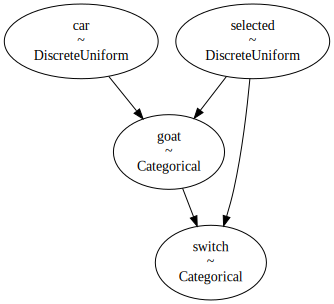

In [4]:
pm.model_graph.model_to_graphviz(model)

### Bonus: Simulating for more than 3 doors

Going slightly off-topic here from PyMC implementation. In the above simulations, we have seen that with 3 doors, we are twice as likely to win by switching ($\frac{2}{3}$ vs. $\frac{1}{3}$). How does this pattern hold with more than 3 doors?

I've decided to implement this in numba to ensure it samples quickly. As the models are quite straightforward (i.e. we're only sampling from discrete uniform distributions), we can use numpy and numba which is faster than PyMC for such basic modelling.

In [5]:
from typing import List, NamedTuple, Iterable, Tuple
import numpy as np
from numba import jit


# Faster numba/numpy implementation to allow more iterations
@jit(nopython = True, fastmath = True)
def monty_hall_nb(n_doors: int = 3) -> Tuple[bool, bool]:
    doors = np.arange(0, n_doors)
    selected = np.random.choice(doors)
    car = np.random.choice(doors)
    goat = np.random.choice(doors[(doors != car) & (doors != selected)])
    switch = np.random.choice(doors[(doors != goat) & (doors != selected)])
    return switch == car, selected == car

class Result(NamedTuple):
    n_doors: int
    iterations: int
    switch: int
    stay: int

def monty_hall_extended(num_doors: Iterable[int], iterations: int) -> List[Result]:
    retval = []
    for n_doors in num_doors:
        res = [monty_hall_nb(n_doors) for _ in range(iterations)]
        switch, stay = sum(x[0] for x in res), sum(x[1] for x in res)
        retval.append(Result(n_doors, iterations, switch, stay))
    return retval

# takes a couple of minutes
results = monty_hall_extended(range(3, 101), 1_000_000)

#### Plotting out the results

The advantage significantly reduces with an increasing number of doors and becomes negligible with more than 20 doors. The probability of winning for the two strategies for $N$ doors can be shown as:

Stay: $\frac{1}{N}$

Switch: $\frac{N - 1}{N} \times \frac{1}{N-2}$

Ratio $\frac{\text{Switch}}{\text{Stay}}$: $\frac{N-1}{N-2}$

As N increases, the ratio converges to 1.

<Figure size 1440x720 with 0 Axes>

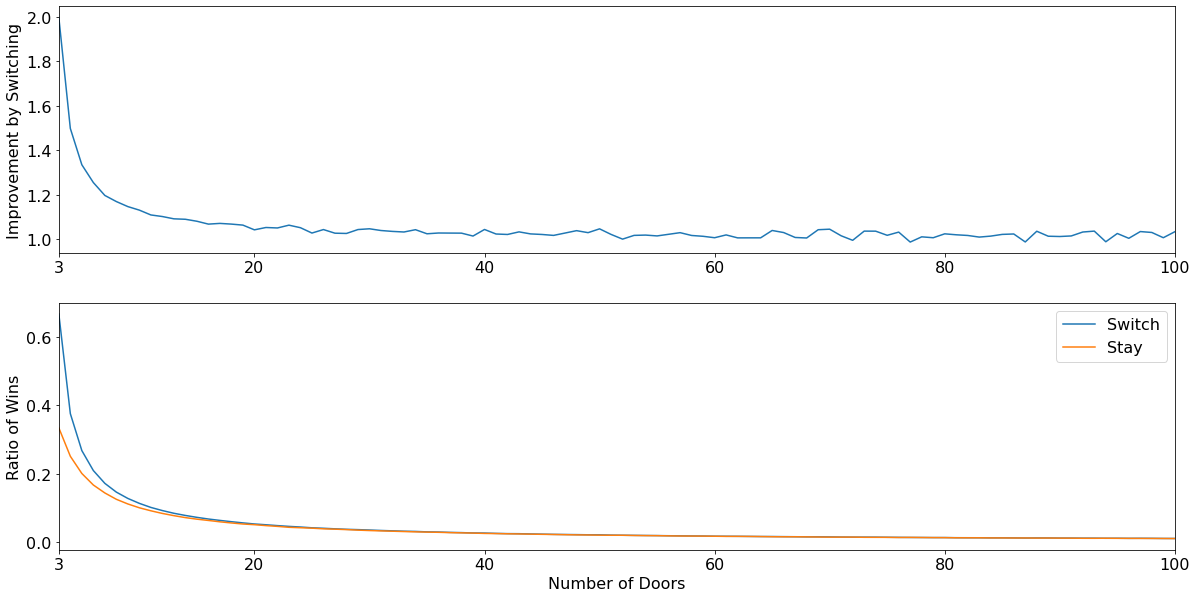

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,10))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

y_switch = np.array([r.switch/r.iterations for r in results])
y_stay = np.array([r.stay/r.iterations for r in results])
y_ratio = y_switch/y_stay
x = np.array([r.n_doors for r in results])

ax1.plot(x, y_ratio)
ax2.plot(x, y_switch)
ax2.plot(x, y_stay)
ax2.set_xlabel('Number of Doors')
ax1.set_ylabel('Improvement by Switching')
ax2.set_ylabel('Ratio of Wins')
ax2.legend(['Switch', 'Stay'])
ax1.set_xlim([min(x), max(x)])
ax2.set_xlim([min(x), max(x)])
ax1.set_xticks([3, 20, 40, 60, 80, 100])
ax2.set_xticks([3, 20, 40, 60, 80, 100])
plt.show()

In [7]:
import matplotlib
import numba
import sys
print(f"matplotlib version: {matplotlib.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"PyMC3 version: {pm.__version__}")
print(f"Python version: {sys.version.split(' ')[0]}")

matplotlib version: 3.3.3
Numba version: 0.52.0
NumPy version: 1.18.4
PyMC3 version: 3.10.0
Python version: 3.8.2
